# Using FastAI ULMFiT to make a state-of-the-art text classifier

Refer to the full tutorial here:
https://medium.com/technonerds/using-fastais-ulmfit-to-make-a-state-of-the-art-multi-label-text-classifier-bf54e2943e83

## 0. Setup

In [35]:
from fastai.text import *
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', -1)

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Import the data

In [36]:
text_path = 'gdrive/My Drive/Developer/Datasets/stackoverflow-dataset/title_StackOverflow.txt'
label_path = 'gdrive/My Drive/Developer/Datasets/stackoverflow-dataset/label_StackOverflow.txt'

df_text = pd.read_csv(text_path, sep='\t', names=['text'], header=None)
df_label = pd.read_csv(label_path, sep='\t', names=['label'], header=None)

df = pd.concat([df_label, df_text], axis=1, sort=False)
print('Length of dataset: '+str(len(df.index)))
df.head()

Length of dataset: 20000


,label,text
0,18,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,18,How do you page a collection with LINQ?
2,3,Best Subversion clients for Windows Vista (64bit)
3,3,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,7,Visual Studio Setup Project - Per User Registry Settings


In [37]:
mapping = {
  1: 'wordpress',
  2: 'oracle',
  3: 'svn',
  4: 'apache',
  5: 'excel',
  6: 'matlab',
  7: 'visual-studio',
  8: 'cocoa',
  9: 'osx',
  10: 'bash',
  11: 'spring',
  12: 'hibernate',
  13: 'scala',
  14: 'sharepoint',
  15: 'ajax',
  16: 'qt',
  17: 'drupal',
  18: 'linq',
  19: 'haskell',
  20: 'magento'
}

df['label'] = df['label'].map(mapping)

df.head()

,label,text
0,linq,How do I fill a DataSet or a DataTable from a LINQ query resultset ?
1,linq,How do you page a collection with LINQ?
2,svn,Best Subversion clients for Windows Vista (64bit)
3,svn,"Best Practice: Collaborative Environment, Bin Directory, SVN"
4,visual-studio,Visual Studio Setup Project - Per User Registry Settings


## 2. Create train & validation datasets and FastAI data bunch

In [38]:
from sklearn.model_selection import train_test_split

df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.3)

df_trn.shape, df_val.shape

((14000, 2), (6000, 2))

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [40]:
data_clas.show_batch()

text,target
"xxbos xxmaj why do i receive a "" xxmaj out of xxmaj windows xxmaj resources "" warning when i open numerous figure windows in xxup matlab [ 7.0 ( xxup xxunk ) and beyond ] on a xxmaj microsoft xxmaj windows xxup pc ?",matlab
xxbos xxmaj remove xxmaj single xxmaj quotes xxmaj from xxmaj all xxmaj cells in a datatable - xxmaj creating xxmaj new xxmaj table - xxmaj using xxup linq in xxmaj vb . xxmaj net,linq
xxbos xxmaj what 's the best way to find if the processor type is xxup ppc or xxmaj intel in xxmaj cocoa ? ( xxmaj do i have to use xxmaj carbon ? ),osx
"xxbos xxmaj in xxmaj oracle xxmaj xxunk ( xxup xxunk ) , is there a way to get the xxunk point of a polygon that is contained by the surface of the polygon ?",oracle
"xxbos xxmaj configuring xxmaj apache to route "" xxup get / user / foo "" to / user / xxunk and "" xxup put / user / foo "" to / user / xxunk",apache


In [0]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')
data_lm = load_data('./', 'data_lm_export.pkl')
data_clas = load_data('./', 'data_clas_export.pkl', bs=64)

## 3. Create and Train the Language Model

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 7.59E-02


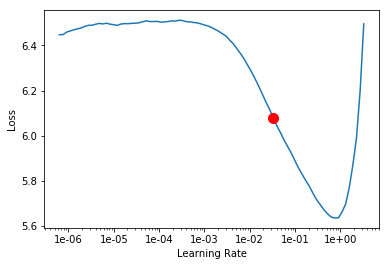

In [43]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [44]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.840412,4.063015,0.314076,00:14
1,4.135231,3.952360,0.322781,00:14


In [45]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.542882,3.825899,0.336423,00:18
1,3.368596,3.830364,0.338944,00:18


In [46]:
learn.predict("How do", n_words=10)

'How do i get status object record in my MS'

In [0]:
learn.save_encoder('ft_enc')

## 4. Using the Language Model to Train the Classifier

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 1.74E-02


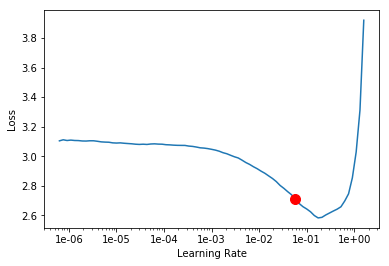

In [49]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [50]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.806202,1.342678,0.605000,00:10
1,1.391742,1.032389,0.720333,00:10


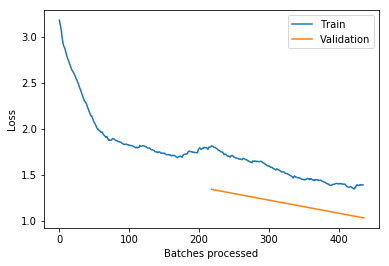

In [51]:
learn.recorder.plot_losses()

In [52]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.309619,0.798372,0.779833,00:11
1,1.057222,0.642959,0.819667,00:12
2,0.841182,0.595715,0.832667,00:12
3,0.754000,0.586629,0.832667,00:12


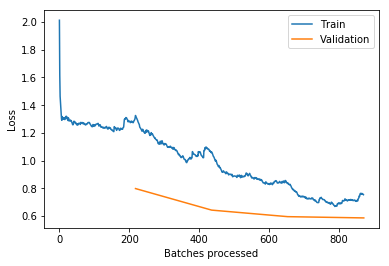

In [53]:
learn.recorder.plot_losses()

In [54]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.653609,0.558160,0.838167,00:23
1,0.582657,0.532493,0.846000,00:22
2,0.516326,0.517132,0.851333,00:25
3,0.472621,0.516339,0.852833,00:26


## 5. Analyzing our results

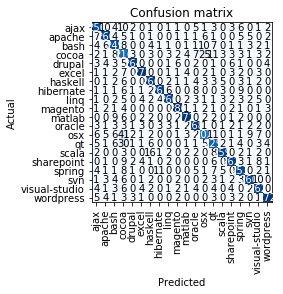

In [55]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [56]:
interp.most_confused()

[('osx', 'cocoa', 41),
 ('qt', 'cocoa', 30),
 ('cocoa', 'osx', 25),
 ('scala', 'haskell', 16),
 ('cocoa', 'qt', 11),
 ('osx', 'qt', 11),
 ('spring', 'hibernate', 11),
 ('ajax', 'apache', 10),
 ('ajax', 'cocoa', 10),
 ('bash', 'osx', 10),
 ('svn', 'visual-studio', 10),
 ('hibernate', 'spring', 9),
 ('matlab', 'bash', 9),
 ('osx', 'svn', 9),
 ('sharepoint', 'cocoa', 9),
 ('bash', 'cocoa', 8),
 ('cocoa', 'bash', 8),
 ('hibernate', 'oracle', 8),
 ('scala', 'qt', 8),
 ('sharepoint', 'visual-studio', 8),
 ('spring', 'cocoa', 8),
 ('apache', 'ajax', 7),
 ('bash', 'qt', 7),
 ('cocoa', 'oracle', 7),
 ('excel', 'cocoa', 7),
 ('osx', 'visual-studio', 7),
 ('spring', 'qt', 7),
 ('ajax', 'spring', 6),
 ('apache', 'osx', 6),
 ('bash', 'apache', 6),
 ('drupal', 'magento', 6),
 ('drupal', 'sharepoint', 6),
 ('haskell', 'cocoa', 6),
 ('hibernate', 'cocoa', 6),
 ('hibernate', 'linq', 6),
 ('matlab', 'cocoa', 6),
 ('osx', 'ajax', 6),
 ('osx', 'bash', 6),
 ('qt', 'bash', 6),
 ('qt', 'haskell', 6),
 ('shar

## 6. Predictions

In [57]:
learn.predict("homebrew not working")

(Category cocoa,
 tensor(3),
 tensor([0.1329, 0.0255, 0.0075, 0.2108, 0.0212, 0.0048, 0.0121, 0.0144, 0.0074,
         0.1576, 0.0061, 0.0078, 0.0666, 0.1396, 0.0068, 0.0484, 0.0539, 0.0068,
         0.0418, 0.0280]))

## 7. Export the model

In [0]:
learn.export()